#### Import

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, classification_report)

In [22]:
# Load Dataset
df = pd.read_csv('heart_attack_prediction_dataset.csv')

In [23]:
pd.set_option('display.max_columns', None)

In [24]:
columns_to_drop = ['Hemisphere', 'Patient ID', 'Continent', 'Patient ID', 'Family History', 'Sex', 'Country', 'Income', 'Diet', 'Obesity', 'Smoking', 'Blood Pressure', 'Alcohol Consumption', 'Exercise Hours Per Week','Previous Heart Problems', 'Medication Use', 'Sedentary Hours Per Day','Physical Activity Days Per Week', 'Sleep Hours Per Day']
df.drop(columns_to_drop, axis=1, inplace=True)
df.head()

,Age,Cholesterol,Heart Rate,Diabetes,Stress Level,BMI,Triglycerides,Heart Attack Risk
0,67,208,72,0,9,31.251233,286,0
1,21,389,98,1,1,27.194973,235,0
2,21,324,72,1,9,28.176571,587,0
3,84,383,73,1,9,36.464704,378,0
4,66,318,93,1,6,21.809144,231,0


In [25]:
x = df.drop('Heart Attack Risk', axis = 1)
y = df['Heart Attack Risk']

In [26]:
# Splitting Data into Training and Test sets 

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### Pipelines with and without PCA + Class weight

In [27]:
pipelines = {
    "LogReg_NoPCA": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="liblinear"
        ))
    ]),
    
    "LogReg_PCA": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="liblinear"
        ))
    ]),
    
    "SVM_NoPCA": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(
            probability=True,
            class_weight="balanced"
        ))
    ]),
    
    "SVM_PCA": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', SVC(
            probability=True,
            class_weight="balanced"
        ))
    ]),
    
    # KNN does NOT support class_weight (left unchanged)
    "KNN_NoPCA": Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]),
    
    "KNN_PCA": Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('model', KNeighborsClassifier())
    ])
}


#### Hyper parameter grids

In [28]:
param_grids = {
    "LogReg_NoPCA": {
        'model__C': [0.01, 0.1, 1, 10]
    },
    
    "LogReg_PCA": {
        'pca__n_components': [0.90, 0.95, 0.99],
        'model__C': [0.01, 0.1, 1, 10]
    },
    
    "SVM_NoPCA": {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear']
    },
    
    "SVM_PCA": {
        'pca__n_components': [0.90, 0.95, 0.99],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear']
    },
    
    "KNN_NoPCA": {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    },
    
    "KNN_PCA": {
        'pca__n_components': [0.90, 0.95, 0.99],
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    }
}

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)

results = []

for name, pipeline in pipelines.items():
    print(f"\n================ {name} =================")

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )

    grid.fit(xtrain, ytrain.values.ravel())
    best_model = grid.best_estimator_

    y_pred = best_model.predict(xtest)
    y_prob = best_model.predict_proba(xtest)[:, 1]

    print("Best Parameters:")
    print(grid.best_params_)

    print("\nClassification Report:")
    print(classification_report(ytest, y_pred, zero_division=0))

    pca_step = best_model.named_steps.get('pca', None)

    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(ytest, y_pred),
        "Precision": precision_score(ytest, y_pred, zero_division=0),
        "Recall": recall_score(ytest, y_pred, zero_division=0),
        "F1-score": f1_score(ytest, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(ytest, y_prob),
        "PCA_Used": pca_step is not None,
        "PCA_Components": pca_step.n_components_ if pca_step else "N/A"
    }

    results.append(metrics)



================ LogReg_NoPCA =================
Best Parameters:
{'model__C': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.48      0.55      1125
           1       0.36      0.52      0.42       628

    accuracy                           0.50      1753
   macro avg       0.50      0.50      0.49      1753
weighted avg       0.54      0.50      0.51      1753


================ LogReg_PCA =================
Best Parameters:
{'model__C': 0.1, 'pca__n_components': 0.9}

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.48      0.55      1125
           1       0.36      0.52      0.42       628

    accuracy                           0.50      1753
   macro avg       0.50      0.50      0.49      1753
weighted avg       0.54      0.50      0.51      1753


================ SVM_NoPCA =================
Best Parameters:
{'model__C': 1, 'model__kernel': 'rbf'}

Cl

In [30]:
# Display results
print("\n============= SUMMARY OF RESULTS ======\n")
results_df = pd.DataFrame(results)
results_df


============= SUMMARY OF RESULTS ======



,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,PCA_Used,PCA_Components
0,LogReg_NoPCA,0.496292,0.359116,0.517516,0.424005,0.506616,False,N/A
1,LogReg_PCA,0.496292,0.359116,0.517516,0.424005,0.506616,True,7
2,SVM_NoPCA,0.504849,0.365471,0.519108,0.428947,0.514926,False,N/A
3,SVM_PCA,0.504849,0.365471,0.519108,0.428947,0.485074,True,7
4,KNN_NoPCA,0.596121,0.394180,0.237261,0.296223,0.522251,False,N/A
5,KNN_PCA,0.596121,0.394180,0.237261,0.296223,0.522251,True,7


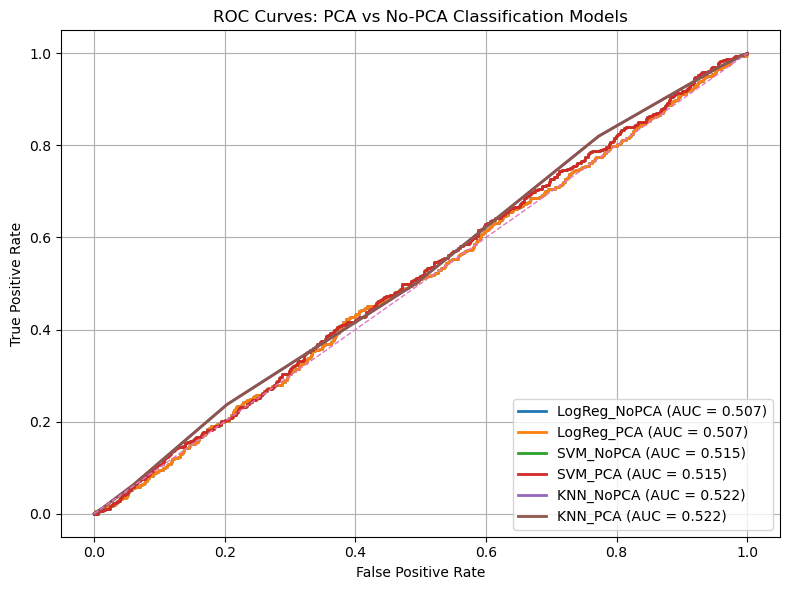

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for name, pipeline in pipelines.items():

    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        scoring='roc_auc',
        cv=5,
        n_jobs=-1
    )

    grid.fit(xtrain, ytrain)
    best_model = grid.best_estimator_

    y_prob = best_model.predict_proba(xtest)[:, 1]

    # ROC curve
    fpr, tpr, _ = roc_curve(ytest, y_prob)
    roc_auc = auc(fpr, tpr)

    label = f"{name} (AUC = {roc_auc:.3f})"
    plt.plot(fpr, tpr, linewidth=2, label=label)

# Reference line
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: PCA vs No-PCA Classification Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Cluster visualization (2D PCA)

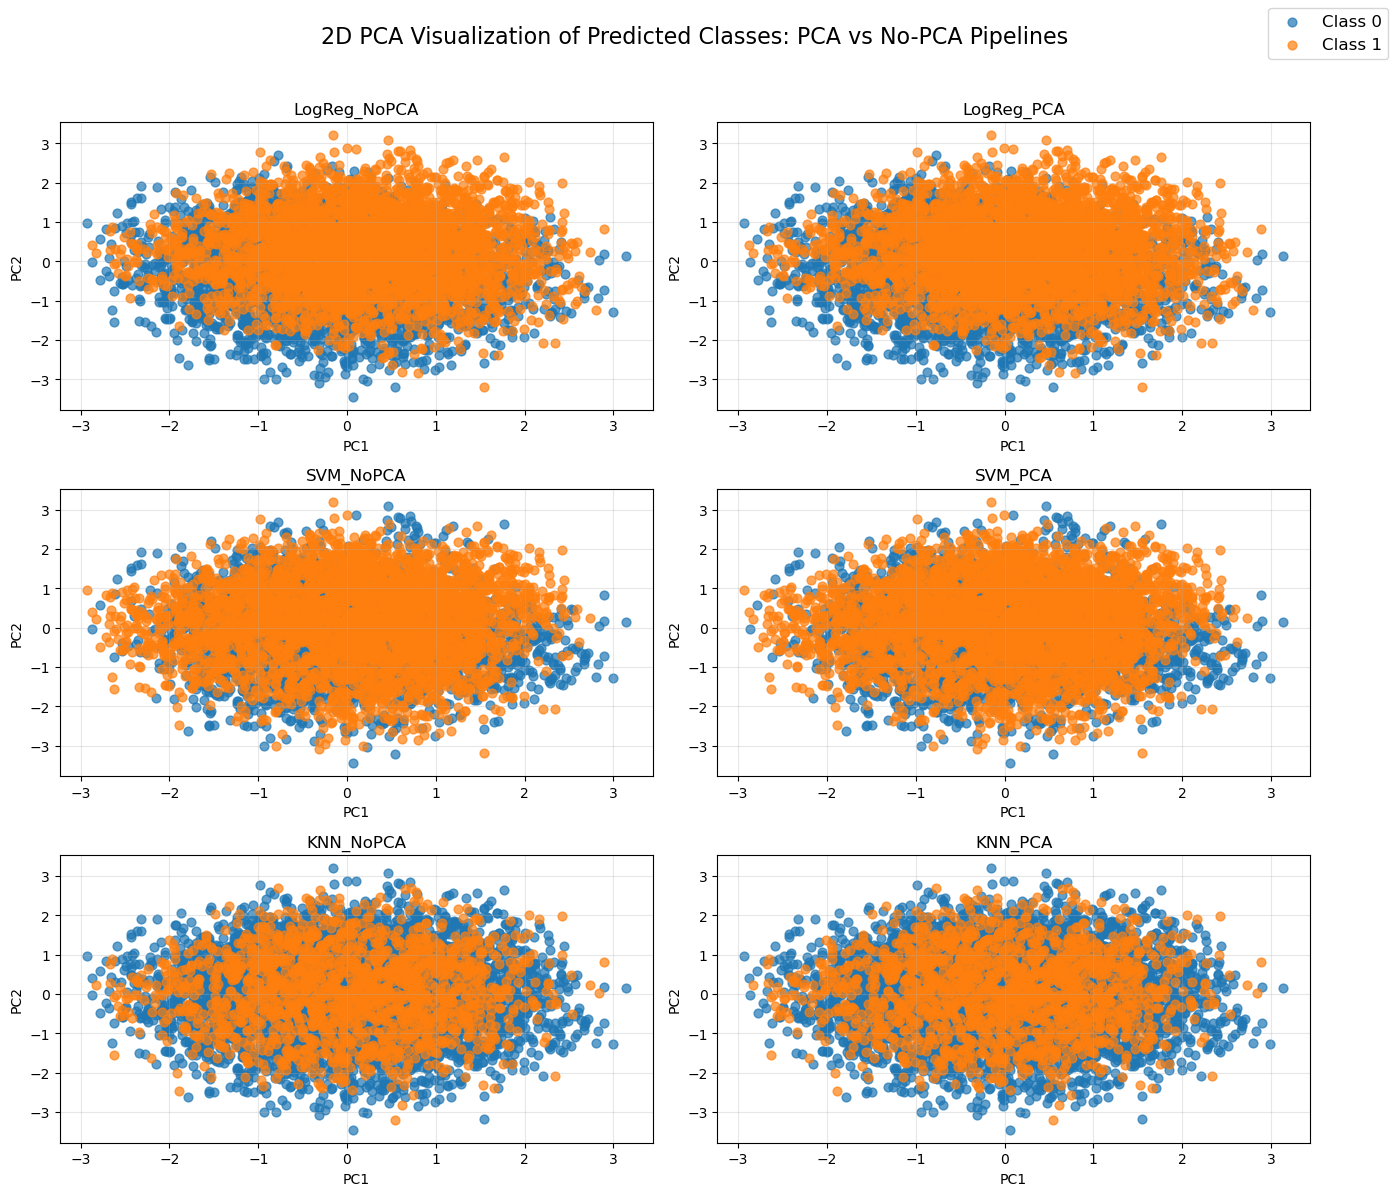

In [32]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function for plotting a single subplot
def plot_subplot(ax, X, y_pred, title):
    """
    Plot PCA 2D projection on a specific subplot.
    """
    unique_classes = np.unique(y_pred)
    for cls in unique_classes:
        mask = y_pred == cls
        ax.scatter(
            X[mask, 0],
            X[mask, 1],
            s=40,
            alpha=0.7,
            label=f"Class {cls}"
        )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("PC1", fontsize=10)
    ax.set_ylabel("PC2", fontsize=10)
    ax.grid(alpha=0.3)

# Prepare figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,12))
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Row / column mapping
model_order = ["LogReg", "SVM", "KNN"]
pipeline_types = ["NoPCA", "PCA"]

# Loop through rows (models)
for i, model_name in enumerate(model_order):
    for j, pca_type in enumerate(pipeline_types):
        pipeline_key = f"{model_name}_{pca_type}"
        pipeline = pipelines[pipeline_key]
        
        # Fit pipeline
        pipeline.fit(xtrain, ytrain.values.ravel())
        y_pred = pipeline.predict(xtrain)
        
        # Transform features for 2D plotting
        if 'pca' in pipeline.named_steps:
            X_viz = pipeline.named_steps['pca'].transform(
                pipeline.named_steps['scaler'].transform(xtrain)
            )
        else:
            # No-PCA: scale then temporary PCA for 2D plot
            X_scaled = pipeline.named_steps['scaler'].transform(xtrain)
            X_viz = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
        
        # Plot in correct subplot
        plot_subplot(axes[i,j], X_viz, y_pred, title=pipeline_key)

# Add common legend
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=12)

plt.suptitle("2D PCA Visualization of Predicted Classes: PCA vs No-PCA Pipelines", fontsize=16)
plt.tight_layout(rect=[0,0,0.95,0.96])
plt.show()

#### PCA Loadings

In [33]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(xtrain)

# Fit PCA (use same n_components as best model)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

In [34]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=xtrain.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Age,-0.301023,-0.443858,0.321494,-0.353829,0.686890,-0.062520,0.089972
Cholesterol,0.645796,-0.035227,0.069542,-0.292056,-0.020140,-0.066021,0.697717
Heart Rate,0.044776,0.345694,0.627874,0.430658,0.116429,-0.532035,0.046714
Diabetes,-0.266779,0.530744,-0.336628,0.232350,0.468546,0.254570,0.442148
Stress Level,-0.535695,-0.335470,0.148599,0.227466,-0.472140,0.041365,0.549582


In [35]:
# Aggregate absolute loadings across components
feature_importance = loadings.abs().mean(axis=1)

# Rank features
feature_importance = feature_importance.sort_values(ascending=False)

feature_importance.head(10)

Diabetes         0.361680
BMI              0.330482
Stress Level     0.330046
Triglycerides    0.323946
Age              0.322798
Heart Rate       0.306311
Cholesterol      0.260929
dtype: float64

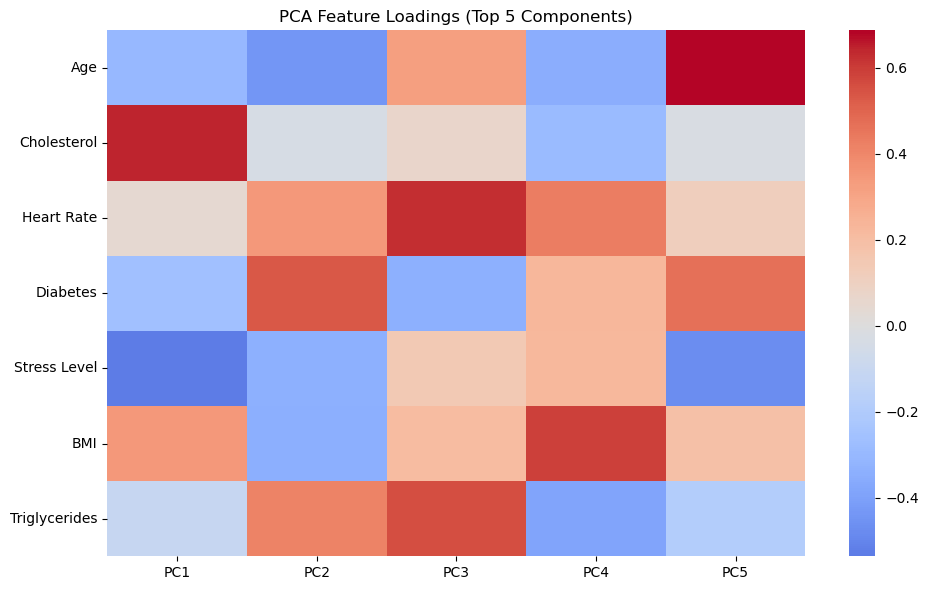

In [36]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(loadings.iloc[:, :5], cmap="coolwarm", center=0)
plt.title("PCA Feature Loadings (Top 5 Components)")
plt.tight_layout()
plt.show()

#### PCA Feature Contribution (Variance-based

In [39]:
# Extract steps
scaler = best_model.named_steps['scaler']
pca = best_model.named_steps['pca']
model = best_model.named_steps['model']

# Transform training data exactly as model saw it
X_train_scaled = scaler.transform(xtrain)
X_train_pca = pca.transform(X_train_scaled)

In [43]:
import shap

explainer = shap.KernelExplainer(
    model.predict_proba,
    X_train_pca[:100]  # background in PCA space
)

shap_values = explainer(X_train_pca)

# Binary classification → class 1
shap_vals = shap_values.values
if shap_vals.ndim == 3:
    shap_vals = shap_vals[:, :, 1]

shap_importance_pca = np.abs(shap_vals).mean(axis=0)

shap_importance_pca = pd.Series(
    shap_importance_pca,
    index=[f"PC{i+1}" for i in range(X_train_pca.shape[1])],
    name="SHAP_importance_PCA"
)

print(shap_importance_pca.head())

  0%|          | 0/7010 [00:00<?, ?it/s]

PC1    0.030040
PC2    0.025191
PC3    0.026821
PC4    0.027589
PC5    0.026092
Name: SHAP_importance_PCA, dtype: float64


In [44]:
# PCA loadings
pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=xtrain.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Aggregate absolute loadings per PC
pca_loading_strength = pca_loadings.abs().mean(axis=0)

comparison = pd.concat(
    [pca_loading_strength.rename("Avg_Loading_Magnitude"),
     shap_importance_pca],
    axis=1
)

print(comparison.head(10))

     Avg_Loading_Magnitude  SHAP_importance_PCA
PC1               0.321303             0.030040
PC2               0.349612             0.025191
PC3               0.325781             0.026821
PC4               0.359133             0.027589
PC5               0.306142             0.026092
PC6               0.298535             0.027380
PC7               0.275684             0.025832


In [45]:
from scipy.stats import pearsonr, spearmanr

# Aggregate PCA loading magnitude per PC
pca_loading_strength = pca_loadings.abs().mean(axis=0)

# Align indices
comparison_df = pd.concat(
    [
        pca_loading_strength.rename("PCA_Loading_Strength"),
        shap_importance_pca.rename("SHAP_Importance")
    ],
    axis=1
).dropna()

# Pearson (linear relationship)
pearson_corr, pearson_p = pearsonr(
    comparison_df["PCA_Loading_Strength"],
    comparison_df["SHAP_Importance"]
)

# Spearman (rank-based relationship)
spearman_corr, spearman_p = spearmanr(
    comparison_df["PCA_Loading_Strength"],
    comparison_df["SHAP_Importance"]
)

print("PCA vs SHAP Correlation Statistics")
print("---------------------------------")
print(f"Pearson r   = {pearson_corr:.3f} (p = {pearson_p:.3e})")
print(f"Spearman ρ = {spearman_corr:.3f} (p = {spearman_p:.3e})")


PCA vs SHAP Correlation Statistics
---------------------------------
Pearson r   = 0.103 (p = 8.264e-01)
Spearman ρ = 0.179 (p = 7.017e-01)


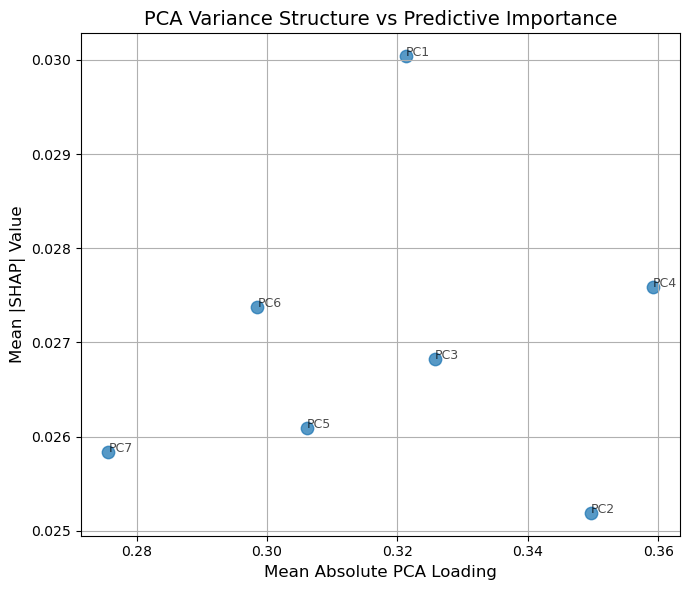

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(
    comparison_df["PCA_Loading_Strength"],
    comparison_df["SHAP_Importance"],
    s=80,
    alpha=0.75
)

# Annotate PCs
for pc in comparison_df.index:
    plt.annotate(
        pc,
        (comparison_df.loc[pc, "PCA_Loading_Strength"],
         comparison_df.loc[pc, "SHAP_Importance"]),
        fontsize=9,
        alpha=0.7
    )

plt.xlabel("Mean Absolute PCA Loading", fontsize=12)
plt.ylabel("Mean |SHAP| Value", fontsize=12)
plt.title("PCA Variance Structure vs Predictive Importance", fontsize=14)

plt.grid(True)
plt.tight_layout()
plt.show()

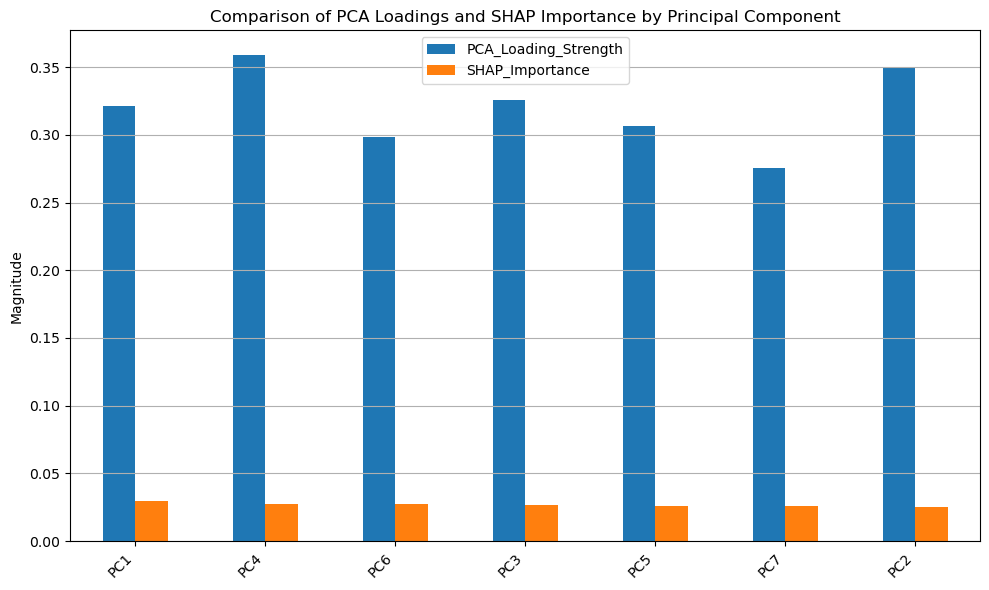

In [47]:
#Ranked Comparison Bar Chart

comparison_df_sorted = comparison_df.sort_values(
    "SHAP_Importance", ascending=False
)

comparison_df_sorted.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.ylabel("Magnitude")
plt.title("Comparison of PCA Loadings and SHAP Importance by Principal Component")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

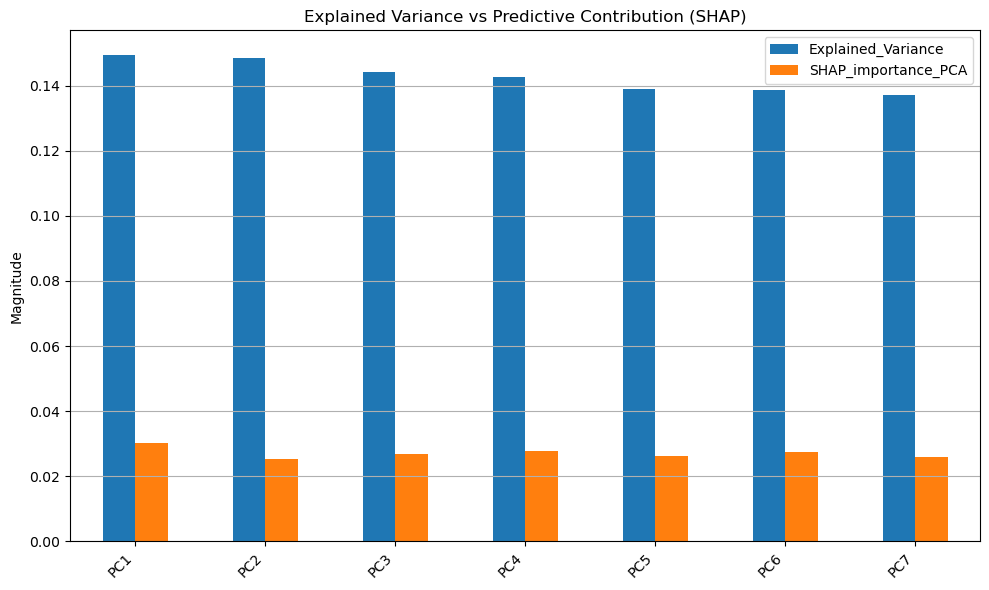

In [48]:
explained_variance = pd.Series(
    pca.explained_variance_ratio_,
    index=comparison_df.index,
    name="Explained_Variance"
)

variance_shap_df = pd.concat(
    [explained_variance, shap_importance_pca],
    axis=1
)

variance_shap_df.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.ylabel("Magnitude")
plt.title("Explained Variance vs Predictive Contribution (SHAP)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()